<a href="https://colab.research.google.com/github/StarBlossom99/Pytorch_Study/blob/main/2022_0208/pytorch_study_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

실제로 충분한 크기의 데이터셋을 갖추기가 힘들기 때문에 매우 큰 데이터셋에서 미리 합성곱 신경망으로 학습한 뒤에 이 합성곱 신경망을 작업을 위한 초기 설정 또는 fixed feature extractor로 사용

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

In [ ]:
!unzip -qq "/content/hymenoptera_data.zip" -d "/content/data"



In [ ]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


학습을 위해 데이터를 정규화한다.

RandomResizedCrop()??

RandomHorizontalFlip()??

Resize()??

CenterCrop()??

data_dir 에 있는 데이터를 data transform을 적용시켜서 image_dataset으로 만들고 그것을 dataloader를 이용하여 가져오게 한다. 

GPU를 사용할 수 있으면 사용

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


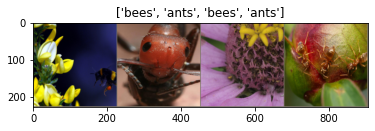

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

numpy().transpose()??

np.clip()??


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

epoch 정확도가 best 정확도보다 나으면 best model을 deepcopy를 통해 바꾼다.

가장 나은 모델의 가중치를 불러와서 리턴



In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

평가 시기이기 때문에 no grad 사용

plt.subplot은 무엇일까 

ax.axis()???


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

model을 이미 있던 model(resnet18)을 가져오고, model의 마지막 fully connected layer의 성질만 nn.linear를 통해 지정해준다.

model 을 gpu로 옮겨서 계산

모든 매개변수는 변할수 있도록

In [ ]:
model_ft = train_model(model_ft,criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5941 Acc: 0.7090
val Loss: 0.1772 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4657 Acc: 0.8074
val Loss: 0.2702 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.6069 Acc: 0.7623
val Loss: 0.4290 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.3605 Acc: 0.8566
val Loss: 0.1874 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4103 Acc: 0.7951
val Loss: 0.3323 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.4825 Acc: 0.7992
val Loss: 0.5080 Acc: 0.8170

Epoch 6/24
----------
train Loss: 0.4202 Acc: 0.8115
val Loss: 0.7671 Acc: 0.7582

Epoch 7/24
----------
train Loss: 0.3601 Acc: 0.8566
val Loss: 0.3366 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.2784 Acc: 0.8730
val Loss: 0.3061 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.4011 Acc: 0.8279
val Loss: 0.2805 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2894 Acc: 0.8852
val Loss: 0.2841 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2446 Acc: 0.8730
val Loss: 0.2724 Acc: 0.9020

Epoch 12/24
----------
t

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

마지막 계층을 제외한 신경망의 모든 부분을 고정
requires_grad를 false로 설정하여 매개변수를 고정


새로 생성된 모듈의 매개변수이외에는 값을 고정하고 사용


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5332 Acc: 0.7336
val Loss: 0.2524 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.3577 Acc: 0.8279
val Loss: 0.3059 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.5382 Acc: 0.7869
val Loss: 0.2198 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4889 Acc: 0.8279
val Loss: 0.4792 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.4984 Acc: 0.8033
val Loss: 0.2068 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5638 Acc: 0.7828
val Loss: 0.2117 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3713 Acc: 0.8443
val Loss: 0.1880 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.4229 Acc: 0.8156
val Loss: 0.1632 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3530 Acc: 0.8607
val Loss: 0.1668 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2812 Acc: 0.8689
val Loss: 0.1521 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4241 Acc: 0.8197
val Loss: 0.1851 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4062 Acc: 0.7828
val Loss: 0.1797 Acc: 0.9477

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


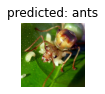

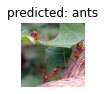

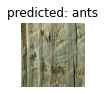

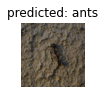

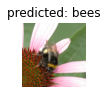

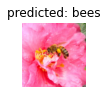

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()